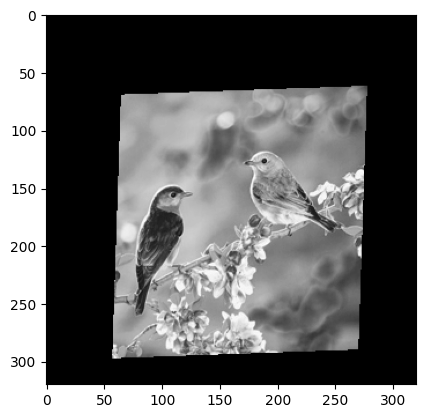

In [1]:
from scipy import ndimage
from matplotlib import pyplot as plt
from numpy import *
from PIL import Image

im = array(Image.open("image1.jpg").convert ("L"))
H = array([[1.4,0.05,-100], [0.05,1.5,-100], [0,0,1]])
im2 = ndimage.affine_transform(im, H[:2,:2], (H[0,2],H[1,2]))
plt.figure()
plt.gray()
plt.imshow(im2)
plt.show()


In [2]:
!pip install homography

In [3]:
import homography
import numpy as np
from scipy import ndimage

def image_in_image(im1, im2, tp):
#Поместить im1 в im2 с помощью аффинного преобразования, так чтобы углы были как можно ближе к tp. Углы tp выражены в однородных координатах и перечисляются против часовой стрелки, начиная с левого верхнего. """
# точки деформируемого изображения
    m,n = im1.shape[:2] #- здесь m и n используются для получения ширины и высоты исходного изображения im1
    fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])
    # вычислить и применить аффинное преобразование
    H = Haffine_from_points(tp, fp) #- здесь создается массив fp, который содержит координаты четырех точек. Первая точка имеет координаты (0, m), вторая точка имеет координаты (0, 0), третья точка имеет координаты (n, n), и четвертая точка имеет координаты (1, 1).
    im1_t=ndimage.affine_transform(im1,H[:2,:2],(H[0,2],H[1,2]),im2.shape[:2]) #- здесь вызывается функция ndimage.affine_transform, которая применяет аффинное преобразование к изображению im1 с использованием матрицы H. H[:2,:2] - это верхняя левая часть матрицы H, которая используется для преобразования осей x и y. (H[0,2],H[1,2]) - это координаты центра преобразования. im2.shape[:2] - это размер изображения im2 по осям x и y, который используется для определения размера выходного изображения.
    alpha = (im1_t > 0) 
    return (1-alpha)*im2 + alpha*im1_t



In [4]:
import numpy as np
from numpy.linalg import svd, inv

def Haffine_from_points (fp, tp) :
  #Найти гомографию Н, отображающую fp в tp.
  if fp.shape != tp.shape:
    raise RuntimeError("расхождение в количестве точек")
  # обеспечить хорошую обусловленность точек
  # --точки первого изображения--
  m = np.mean(fp[:2], axis=1)
  maxstd = max(np.std(fp[:2], axis=1)) + 1e-9
  C1 = np.diag([1/maxstd, 1/maxstd, 1])
  C1[0][2] = -m[0] /maxstd
  C1[1][2] = -m[1] /maxstd
  fp_cond = np.dot (C1, fp)
  # --точки второго изображения—
  m = np.mean(tp[:2], axis=1)
  C2 = C1.copy()# в обоих наборах точек масштаб должен быть одинаков
  C2[0][2] = -m[0] /maxstd
  C2[1][2] = -m[1]/maxstd
  tp_cond = np.dot (C2, tp)
  # после обусловливания среднее точек равно 0, поэтому вектор
  # параллельного переноса нулевой
  A = np.concatenate((fp_cond[:2],tp_cond[:2]), axis = 0)
  U,S,V = svd(A.T)
  # Создать матрицы В и С, как описано у Хартли и Циммермана
  # (второе издание), на стр. 130.
  tmp = V[:2].T
  B= tmp[:2]
  C = tmp[2:4]
  tmp2 = np.concatenate ( (np.dot (C, np.linalg.pinv(B)), np.zeros ((2,1))), axis=1)
  H = np.vstack((tmp2, (0,0,1)))
  # обращение обусловливания
  H = np.dot(inv (C2), np.dot (H,C1))
  return H / H[2,2]


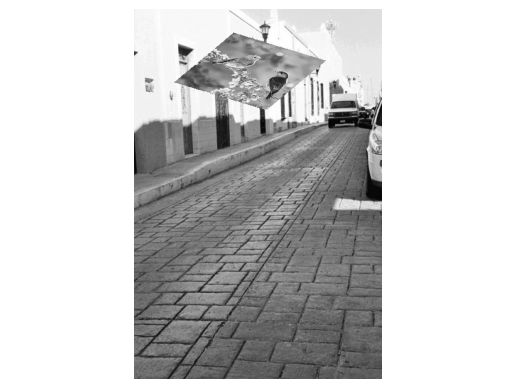

In [5]:

# пример аффинного деформирования im1 в im2
im1 = np.array(Image.open("image1.jpg").convert ("L"))
im2 = np.array(Image.open("image2.jpg").convert ("L"))
# задать точки
tp = np.array([[50, 50,200,50], [200, 50,200,200], [0,0,1,1]])
im3 = image_in_image(im1, im2, tp)
plt.figure()
plt.gray()
plt.imshow(im3)
plt.axis('equal')
plt.axis('off')
plt.show()


In [6]:
def alpha_for_triangle(points,m,n):
#Создает альфа-отображение размера (пл) для треугольника, определенного своими вершинами (заданными нормированными однородными координатами). """

    alpha = np.zeros ((m,n))
    for i in range (min(points[0]),max (points [0])):
        for j in range(min(points[1]) ,max (points [1])):
            x=linalg.solve (points, [i,j,1])
            if min(x) > 0: #все коэффициенты положительные
                alpha[i,j] = 1
    return alpha


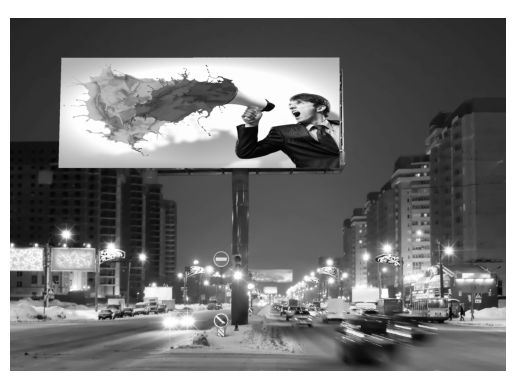

In [7]:

im1 = np.array(Image.open("image4.jpg").convert ("L"))
im2 = np.array(Image.open("image5.jpg").convert ("L"))
# сопоставим исходные точки углам im1
m,n = im1.shape[:2]
fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])
tp = np.array([ [200, 760, 760,200],
               [260, 245, 1670,1670],
               [1, 1, 1, 1]])             # веса (в данном случае все равны 1)
# первый треугольник
tp2=tp[:,:3]
fp2=fp[:,:3]
# вычислить H
H = Haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1,H[:2,:2],
                                 (H[0,2],H[1,2]),im2.shape[:2])
# альфа – отображение для треугольника
alpha = alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im3 = (1-alpha)*im2 + alpha*im1_t
# второй треугольник
tp2 = tp[:,[0,2,3]]
fp2 = fp[:,[0,2,3]]
# вычислить H
H = Haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, H[:2,:2],
                                 (H[0,2],H[1,2]),im2.shape[:2])
# альфа – отображение для треугольника
alpha = alpha_for_triangle(tp2, im2.shape[0],im2.shape[1])
im4 = (1-alpha)*im3 + alpha*im1_t
plt.figure()
plt.gray()
plt.imshow(im4)
plt.axis('equal')
plt.axis('off')
plt.show()
